In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Input folders
RAW_DATA_DIR = "../data/raw/"
INTERIM_DATA_DIR = "../data/interim/"
PROCESSED_DATA_DIR = "../data/processed/"

In [5]:
data = pd.read_csv(f'{INTERIM_DATA_DIR}6_R_crop_proportion_intensity.csv')
print(data.shape)
print(data.isna().sum().sum())
data.head()

(3331, 20)
0


,grower,farm,field,field_fvid,lat,lng,year,tmin,tmax,gdd,cpba_count,cpba_value,cpbl_count,cpbl_value,cum_gdd,croptype,clas_prop,wei_prop,clas_intensity,wei_intensity
0,Wisconsin Central Farms,WCF,1 Necedah,62992,44.057164,-90.040412,2014,44.815974,83.173633,13.772113,3.307692,3.307692,3.900000,3.900000,1727.895721,43,0.4,0.466667,0.028712,0.033425
1,Wisconsin Central Farms,WCF,13 Nepco N 1/2,62996,44.209406,-90.021382,2014,45.498328,79.713370,12.804045,4.562500,4.500000,8.714286,8.500000,1258.997050,1,0.2,0.133333,0.101801,0.093450
2,Wisconsin Central Farms,WCF,16 13th St,62999,44.100775,-90.050524,2014,45.224964,82.761841,14.263578,1.637500,1.781818,2.190000,2.190000,1688.066890,43,0.4,0.466667,0.070153,0.074486
3,Wisconsin Central Farms,WCF,26 Huebner,63009,44.171606,-89.975877,2014,45.584387,82.216665,13.292737,2.181818,2.000000,4.555556,4.555556,1500.892541,43,0.4,0.466667,0.094635,0.090242
4,Wisconsin Central Farms,WCF,7 N Home,63016,44.329762,-89.931300,2014,45.715179,78.727568,12.237354,1.200000,1.200000,5.500000,5.500000,1011.682193,43,0.4,0.466667,0.037756,0.033817


### Merging Climate Data

In [7]:
import time
from meteostat import Daily, Point
from datetime import datetime
import pandas as pd

def daily_avg_temp(df):
    """
    Compute the daily average temperature.
    If 'tavg' exists, use it; otherwise compute average of 'tmin' and 'tmax'.
    """
    if 'tavg' in df.columns and not df['tavg'].isnull().all():
        return df['tavg']
    elif 'tmin' in df.columns and 'tmax' in df.columns:
        return (df['tmin'] + df['tmax']) / 2
    else:
        return None

def compute_summer_features(lat, lon, year):
    """
    Computes summer (May 1 to Aug 31) features:
      - summer_avg_temp: Average daily temperature
      - summer_hottest_temp: Maximum daily maximum temperature
      - summer_coldest_temp: Minimum daily minimum temperature
      - summer_avg_percip: Average daily precipitation
      - summer_heavy_rainfall_days: Count of days with precipitation > 25 mm
      - summer_temp_variability: Standard deviation of daily average temperature
      - summer_cold_days: Count of summer days with tmin < 5°C
    """
    summer_start = datetime(year, 5, 1)
    summer_end = datetime(year, 8, 31)
    df = Daily(Point(lat, lon), summer_start, summer_end).fetch()
    
    if df.empty:
        return {
            'summer_avg_temp': None,
            'summer_hottest_temp': None,
            'summer_coldest_temp': None,
            'summer_avg_percip': None,
            'summer_heavy_rainfall_days': None,
            'summer_temp_variability': None,
            'summer_cold_days': None,
        }
    
    avg_temp_series = daily_avg_temp(df)
    
    features = {
        'summer_avg_temp': avg_temp_series.mean() if avg_temp_series is not None else None,
        'summer_hottest_temp': df['tmax'].max() if 'tmax' in df.columns else None,
        'summer_coldest_temp': df['tmin'].min() if 'tmin' in df.columns else None,
        'summer_avg_percip': df['prcp'].mean() if 'prcp' in df.columns else None,
        'summer_heavy_rainfall_days': (df['prcp'] > 25).sum() if 'prcp' in df.columns else None,
        'summer_temp_variability': avg_temp_series.std() if avg_temp_series is not None else None,
        'summer_cold_days': (df['tmin'] < 5).sum() if 'tmin' in df.columns else None,
    }
    
    return features

def compute_winter_features(lat, lon, year):
    """
    Computes winter features for December (previous year) and January-February (current year):
      - winter_avg_temp: Average daily temperature
      - winter_hottest_temp: Maximum daily maximum temperature
      - winter_coldest_temp: Minimum daily minimum temperature
      - winter_heavy_rainfall_days: Count of days with precipitation > 25 mm
      - winter_temp_variability: Standard deviation of daily average temperature
      - winter_warm_day_count: Count of winter days with average temperature > 5°C
    """
    # Winter period: December of previous year and Jan-Feb of current year
    start_dec = datetime(year - 1, 12, 1)
    end_dec = datetime(year - 1, 12, 31)
    start_janfeb = datetime(year, 1, 1)
    end_janfeb = datetime(year, 2, 28)  # For simplicity
    
    df_dec = Daily(Point(lat, lon), start_dec, end_dec).fetch()
    df_janfeb = Daily(Point(lat, lon), start_janfeb, end_janfeb).fetch()
    df = pd.concat([df_dec, df_janfeb])
    
    if df.empty:
        return {
            'winter_avg_temp': None,
            'winter_hottest_temp': None,
            'winter_coldest_temp': None,
            'winter_heavy_rainfall_days': None,
            'winter_temp_variability': None,
            'winter_warm_day_count': None,
        }
    
    avg_temp_series = daily_avg_temp(df)
    
    features = {
        'winter_avg_temp': avg_temp_series.mean() if avg_temp_series is not None else None,
        'winter_hottest_temp': df['tmax'].max() if 'tmax' in df.columns else None,
        'winter_coldest_temp': df['tmin'].min() if 'tmin' in df.columns else None,
        'winter_heavy_rainfall_days': (df['prcp'] > 25).sum() if 'prcp' in df.columns else None,
        'winter_temp_variability': avg_temp_series.std() if avg_temp_series is not None else None,
        'winter_warm_day_count': (avg_temp_series > 5).sum() if avg_temp_series is not None else None,
    }
    
    return features

def compute_winter_extreme_cold(lat, lon, year):
    """
    Computes the count of extreme winter cold days.
    An extreme cold day is defined as a day with minimum temperature ≤ -15°C.
    The winter period includes December of the previous year and January-February of the current year.
    """
    start_dec = datetime(year - 1, 12, 1)
    end_dec = datetime(year - 1, 12, 31)
    start_janfeb = datetime(year, 1, 1)
    end_janfeb = datetime(year, 2, 28)
    
    df_dec = Daily(Point(lat, lon), start_dec, end_dec).fetch()
    df_janfeb = Daily(Point(lat, lon), start_janfeb, end_janfeb).fetch()
    df = pd.concat([df_dec, df_janfeb])
    
    if df.empty or 'tmin' not in df.columns:
        return None
    
    extreme_cold_days = (df['tmin'] <= -15).sum()
    return extreme_cold_days

def compute_spring_frost_free(lat, lon, year):
    """
    Computes spring frost-free days using data from March 1 to April 30.
    A frost day is defined as a day with tmin ≤ 0°C. 
    The function identifies the last frost day in this period 
    and counts the number of days from that day until the period's end. 
    If no frost occurs, the entire period is frost-free.
    """
    start_date = datetime(year, 3, 1)
    end_date = datetime(year, 4, 30)
    df = Daily(Point(lat, lon), start_date, end_date).fetch()
    
    if df.empty or 'tmin' not in df.columns:
        return None
    
    frost_days = df[df['tmin'] <= 0]
    if frost_days.empty:
        frost_free_days = df.shape[0]
    else:
        last_frost_date = frost_days.index.max()
        frost_free_days = df.loc[last_frost_date:].shape[0]
    
    return frost_free_days

def add_climate_features(df):
    """
    Processes each row of the DataFrame and adds:
      - Summer features (from compute_summer_features)
      - Winter features (from compute_winter_features) plus extreme cold days count
      - Spring frost-free days (from compute_spring_frost_free)
    Returns a new DataFrame with these additional columns.
    """
    summer_features_list = []
    winter_features_list = []
    spring_frost_list = []
    
    for idx, row in df.iterrows():
        lat = row['lat']
        lon = row['lng']
        year = int(row['year'])
        
        summer_feats = compute_summer_features(lat, lon, year)
        winter_feats = compute_winter_features(lat, lon, year)
        # Add extreme cold days to winter features:
        winter_feats['winter_extreme_cold_days'] = compute_winter_extreme_cold(lat, lon, year)
        spring_frost = compute_spring_frost_free(lat, lon, year)
        
        summer_features_list.append(summer_feats)
        winter_features_list.append(winter_feats)
        spring_frost_list.append({'spring_frost_free_days': spring_frost})
        
        if idx % max(1, (len(df) // 10)) == 0:
            print(f"Processed {int((idx / len(df)) * 100)}% of rows...")
    
    summer_df = pd.DataFrame(summer_features_list)
    winter_df = pd.DataFrame(winter_features_list)
    spring_df = pd.DataFrame(spring_frost_list)
    
    df_out = pd.concat([df.reset_index(drop=True), summer_df, winter_df, spring_df], axis=1)
    return df_out

# --------------------
# Main Execution Block
# --------------------


print("Starting climate data processing for the entire dataset...")
start_time = time.time()

# Add the updated climate features for the full dataset
df_with_climate = add_climate_features(data)

end_time = time.time()
print(f"Processed the full dataset in {end_time - start_time:.2f} seconds.\n")
print(df_with_climate)

Starting climate data processing for the entire dataset...


Processed 0% of rows...


Processed 9% of rows...
Processed 19% of rows...


Processed 29% of rows...


Processed 39% of rows...
Processed 49% of rows...
Processed 59% of rows...
Processed 69% of rows...
Processed 79% of rows...
Processed 89% of rows...
Processed 99% of rows...
Processed the full dataset in 303.00 seconds.

                       grower                     farm           field  \
0     Wisconsin Central Farms                      WCF       1 Necedah   
1     Wisconsin Central Farms                      WCF  13 Nepco N 1/2   
2     Wisconsin Central Farms                      WCF      16 13th St   
3     Wisconsin Central Farms                      WCF      26 Huebner   
4     Wisconsin Central Farms                      WCF        7 N Home   
...                       ...                      ...             ...   
3326              Alsum Farms        Alsum Farms Arena             012   
3327        Flyte Family Farm        Flyte Family Farm        Bruchs N   
3328        Flyte Family Farm        Flyte Family Farm      Marotz 7th   
3329              Alsum Farms  Alsum F

In [9]:
df_with_climate.isna().sum()

grower                          0
farm                            0
field                           0
field_fvid                      0
lat                             0
lng                             0
year                            0
tmin                            0
tmax                            0
gdd                             0
cpba_count                      0
cpba_value                      0
cpbl_count                      0
cpbl_value                      0
cum_gdd                         0
croptype                        0
clas_prop                       0
wei_prop                        0
clas_intensity                  0
wei_intensity                   0
summer_avg_temp               155
summer_hottest_temp           155
summer_coldest_temp           155
summer_avg_percip             730
summer_heavy_rainfall_days    155
summer_temp_variability       155
summer_cold_days              155
winter_avg_temp               230
winter_hottest_temp           230
winter_coldest

### Filling NA with nearby Fields data

In [11]:
import numpy as np
from scipy.spatial import cKDTree

# List of climate columns to fill missing values for:
climate_cols = [
    'summer_avg_temp', 'summer_hottest_temp', 'summer_coldest_temp',
    'summer_avg_percip', 'summer_heavy_rainfall_days', 'summer_temp_variability',
    'summer_cold_days', 'winter_extreme_cold_days',
    'winter_avg_temp', 'winter_hottest_temp', 'winter_coldest_temp',
    'winter_heavy_rainfall_days', 'winter_temp_variability', 'winter_warm_day_count',
    'spring_frost_free_days'
]

# Step 1: Separate the rows with missing values and those with complete climate data.
# Rows with missing data in any of the climate columns:
missing_rows = df_with_climate[df_with_climate[climate_cols].isnull().any(axis=1)]
# Rows that have complete data for all the specified climate columns:
non_missing_rows = df_with_climate.dropna(subset=climate_cols)

# If no rows are completely complete, you might need to consider a different approach.
if non_missing_rows.empty:
    raise ValueError("No complete rows available for imputation.")

# Step 2: Build a KDTree on the coordinates (lat, lng) of the complete rows.
non_null_coords = non_missing_rows[['lat', 'lng']].values
null_coords = missing_rows[['lat', 'lng']].values

tree = cKDTree(non_null_coords)
# For each row with missing values, find the single nearest neighbor
distances, indices = tree.query(null_coords, k=1)

# Step 3: Fill missing values with the corresponding data from the nearest non-missing field.
for i, missing_index in enumerate(missing_rows.index):
    # Get the index of the nearest complete row from non_missing_rows.
    nearest_index = non_missing_rows.index[indices[i]]
    # For each climate column, if it is missing, use the nearest field's value.
    for col in climate_cols:
        if pd.isnull(df_with_climate.loc[missing_index, col]):
            df_with_climate.loc[missing_index, col] = df_with_climate.loc[nearest_index, col]

# Step 4: Verify the result by printing the missing value count after imputation.
print("Missing values after filling:")
print(df_with_climate[climate_cols].isnull().sum())

Missing values after filling:
summer_avg_temp               0
summer_hottest_temp           0
summer_coldest_temp           0
summer_avg_percip             0
summer_heavy_rainfall_days    0
summer_temp_variability       0
summer_cold_days              0
winter_extreme_cold_days      0
winter_avg_temp               0
winter_hottest_temp           0
winter_coldest_temp           0
winter_heavy_rainfall_days    0
winter_temp_variability       0
winter_warm_day_count         0
spring_frost_free_days        0
dtype: int64


In [13]:
print("Summary Statistics for Climate Variables:")
print(df_with_climate[climate_cols].describe())

Summary Statistics for Climate Variables:
       summer_avg_temp  summer_hottest_temp  summer_coldest_temp  \
count      3331.000000          3331.000000          3331.000000   
mean         19.212874            34.326569            -0.916842   
std           0.830765             1.799394             2.765464   
min          16.452874            29.900000           -12.000000   
25%          18.851240            33.300000            -2.800000   
50%          19.347967            34.100000            -1.100000   
75%          19.636585            35.000000             0.600000   
max          21.221138            38.300000             6.100000   

       summer_avg_percip  summer_heavy_rainfall_days  summer_temp_variability  \
count        3331.000000                 3331.000000              3331.000000   
mean            3.255993                    2.295707                 4.327188   
std             2.862379                    2.607435                 0.572305   
min             0.811

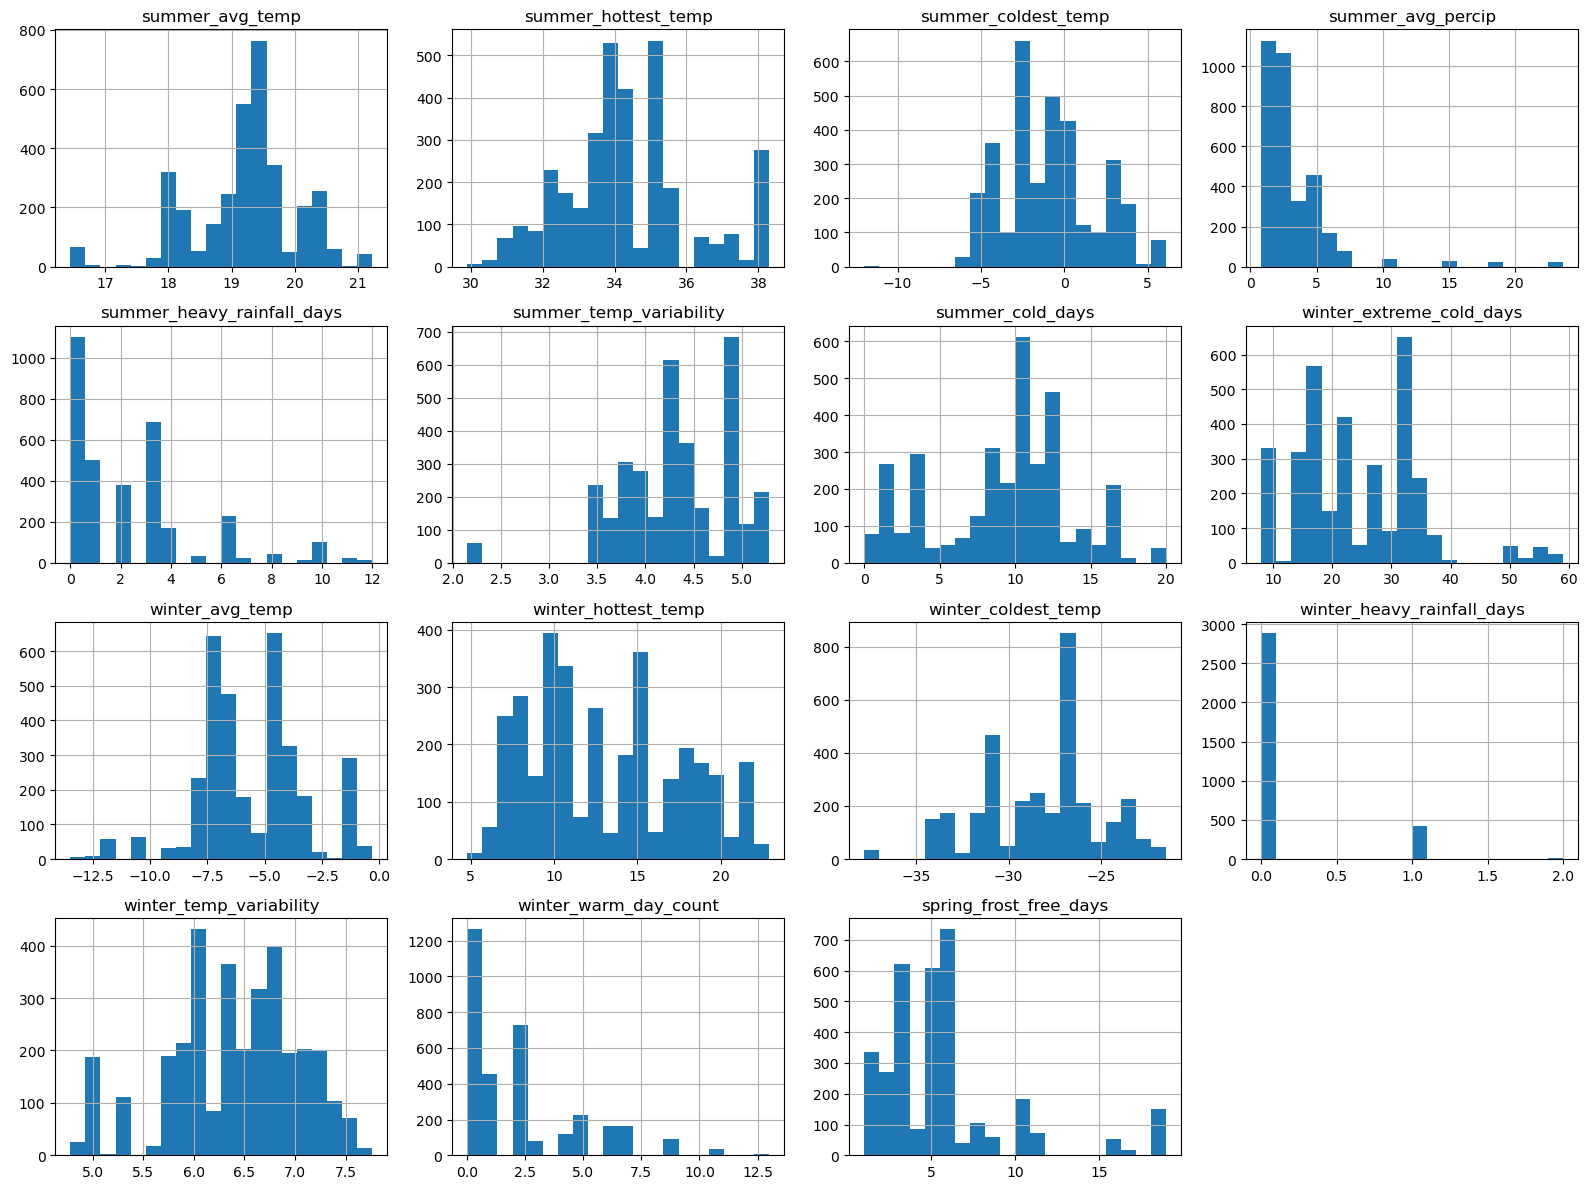

In [15]:
df_with_climate[climate_cols].hist(bins=20, figsize=(16, 12))
plt.tight_layout()
plt.show()


In [17]:
df_with_climate.columns

Index(['grower', 'farm', 'field', 'field_fvid', 'lat', 'lng', 'year', 'tmin',
       'tmax', 'gdd', 'cpba_count', 'cpba_value', 'cpbl_count', 'cpbl_value',
       'cum_gdd', 'croptype', 'clas_prop', 'wei_prop', 'clas_intensity',
       'wei_intensity', 'summer_avg_temp', 'summer_hottest_temp',
       'summer_coldest_temp', 'summer_avg_percip',
       'summer_heavy_rainfall_days', 'summer_temp_variability',
       'summer_cold_days', 'winter_avg_temp', 'winter_hottest_temp',
       'winter_coldest_temp', 'winter_heavy_rainfall_days',
       'winter_temp_variability', 'winter_warm_day_count',
       'winter_extreme_cold_days', 'spring_frost_free_days'],
      dtype='object')

In [21]:
df_with_climate.to_csv(f"{INTERIM_DATA_DIR}7_with_climate_data.csv", index=False)

In [23]:
df_with_climate.isna().sum().sum()

0

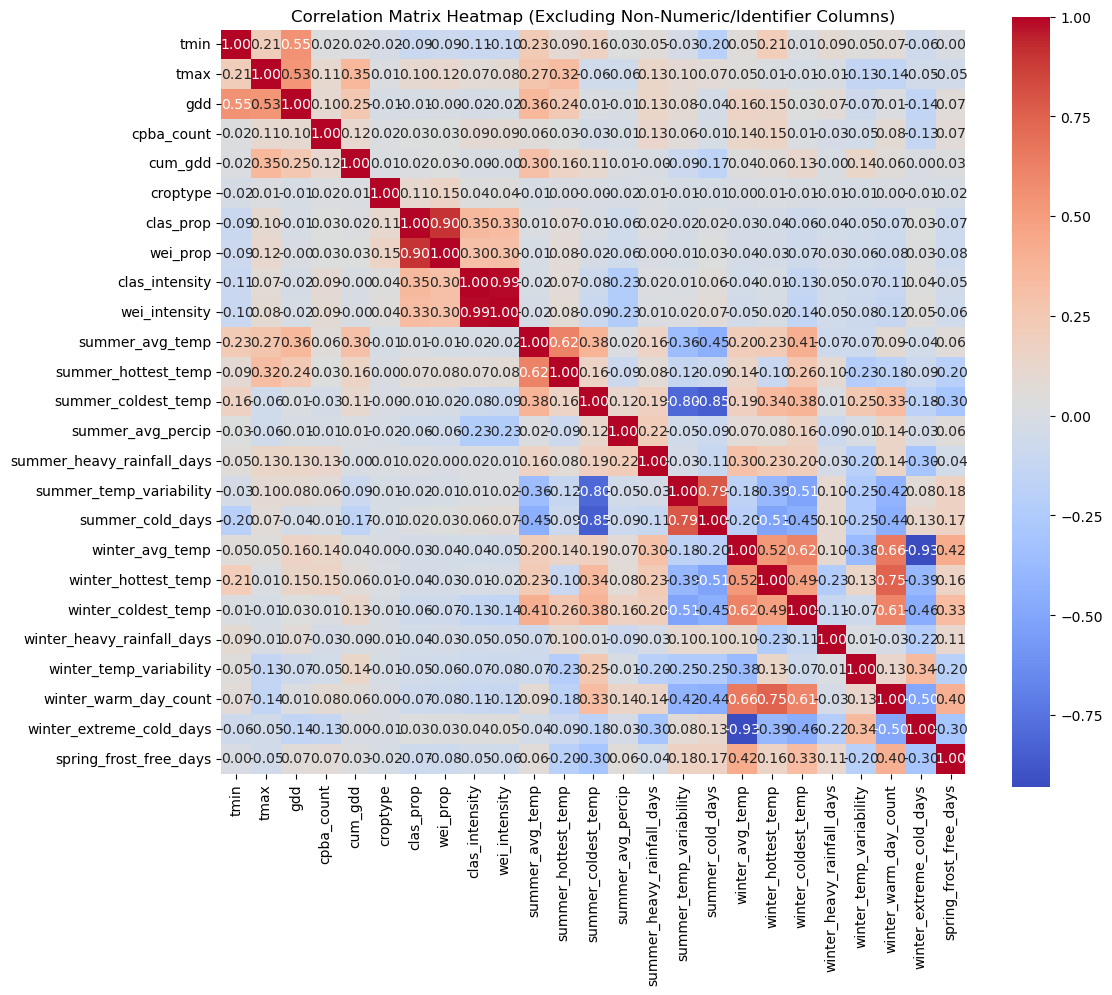

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define columns to exclude
cols_to_drop = ['grower', 'farm', 'field', 'field_fvid', 'lat', 'lng', 'year', 'cpba_value', 'cpbl_count', 'cpbl_value',]  # update as needed

# Create a new DataFrame with the remaining columns
df_corr = df_with_climate.drop(columns=cols_to_drop)

# Compute the correlation matrix on the remaining (mostly numeric) columns
corr_matrix = df_corr.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix Heatmap (Excluding Non-Numeric/Identifier Columns)")
plt.show()

In [ ]:

# Define columns to exclude
cols_to_exclude2 = ['clas_prop','clas_intensity',   'summer_coldest_temp', 'summer_cold_days', 'winter_avg_temp']

# Create a new DataFrame with the remaining columns
df_corr2 = df_corr.drop(columns=cols_to_exclude2)

# Compute the correlation matrix on the remaining (mostly numeric) columns
corr_matrix = df_corr2.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix Heatmap (Excluding Non-Numeric/Identifier Columns)")
plt.show()

In [ ]:
final_exclude_cols = ['tmax', 'tmin']
final_data = df_corr2.drop(columns = final_exclude_cols)
final_data.to_csv('../output_new_data/20may_final_data.csv', index=False)

In [ ]:
final_data.head()

In [ ]:
final_data.columns

In [ ]:
final_data.isna().sum()

### Building Models

In [ ]:
df = pd.read_csv('../data/8apr_final_data_wihtNewClimateVars.csv')
print(df.shape)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# OLS from statsmodels
import statsmodels.api as sm
# Linear models
from sklearn.linear_model import Lasso
# Tree-based models
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
# XGBoost
import xgboost as xgb

df['target'] = (df['cpba_count'] + df['cpbl_count']) / 2

# Define independent features (excluding identifier columns)
feature_cols = [
    'gdd', 'cum_gdd', 'croptype', 'intensity',
    'summer_avg_temp', 'summer_hottest_temp', 'summer_avg_percip',
    'summer_heavy_rainfall_days', 'summer_temp_variability',
    'winter_extreme_cold_days', 'winter_hottest_temp', 'winter_coldest_temp',
    'winter_temp_variability',
    'winter_warm_day_count', 'spring_frost_free_days', 'new_proportion'
]

X = df[feature_cols]
y = df['target']

# If "croptype" is categorical, you might convert it to dummy variables.
# For example:
# X = pd.get_dummies(X, columns=['croptype'], drop_first=True)

# --------------------------
# 2. Train-Test Split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------
# 3. Fit Models and Compare Performance
# --------------------------

# 3a. OLS Regression (using statsmodels)
X_train_sm = sm.add_constant(X_train)  # add constant for the intercept
ols_model = sm.OLS(y_train, X_train_sm).fit()
print("\nOLS Summary:")
print(ols_model.summary())

# OLS predictions
X_test_sm = sm.add_constant(X_test)
y_pred_ols = ols_model.predict(X_test_sm)
ols_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ols))
ols_r2 = r2_score(y_test, y_pred_ols)
print("OLS RMSE: {:.4f}, R2: {:.4f}".format(ols_rmse, ols_r2))

# 3b. Lasso Regression
lasso_model = Lasso(alpha=0.1, random_state=42)  # You can tune alpha as needed.
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
lasso_r2 = r2_score(y_test, y_pred_lasso)
print("Lasso RMSE: {:.4f}, R2: {:.4f}".format(lasso_rmse, lasso_r2))

# 3c. Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)
print("Random Forest RMSE: {:.4f}, R2: {:.4f}".format(rf_rmse, rf_r2))

# 3e. XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2 = r2_score(y_test, y_pred_xgb)
print("XGBoost RMSE: {:.4f}, R2: {:.4f}".format(xgb_rmse, xgb_r2))



In [ ]:
# Create a performance comparison table:
performance = pd.DataFrame({
    "Model": ["OLS", "Lasso", "RandomForest", "XGBoost"],
    "RMSE": [ols_rmse, lasso_rmse, rf_rmse, xgb_rmse],
    "R2": [ols_r2, lasso_r2, rf_r2, xgb_r2]
})
print("\nModel Performance Comparison:")
print(performance)

# --------------------------
# 4. Feature Importance / Coefficients
# --------------------------


# 4b. Lasso Coefficients
lasso_coef = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lasso_model.coef_
})
print("\nLasso Feature Coefficients:")
print(lasso_coef.sort_values(by="Coefficient", key=abs, ascending=False))

# 4c. Random Forest Feature Importance
rf_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
})
print("\nRandom Forest Feature Importance:")
print(rf_importance.sort_values(by="Importance", ascending=False))

# 4e. XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
})
print("\nXGBoost Feature Importance:")
print(xgb_importance.sort_values(by="Importance", ascending=False))